In [1]:
%matplotlib inline

This is a five paremeter room RC model

dT = T(-dt/RC) + T_out(dt/RC) + E_lux(rho1*dt/C) + Occu(Q_int*dt/C) + Rads(Q_rad*dt/C) + q_vav(T_dat-T)*(rho2*dt/C) + dw

rho1: correlation between light intensity sensor and solar gain/electric lighting
rho2: correlation between the mass flow rate and volumetric flow rate
Simplified form:

$$ dT = -T*w_1 + T_out*w_1 + E_lux*w_2 + Occu * w_3 + Rads *w_4 - T*q_vav*w_5 + T_sup * q_vav * w_5 + w_6 $$


In [17]:
import numpy as np
import sympy
w1, w2, w3, w4, w5, w6 = sympy.symbols('w1 w2 w3 w4 w5 w6')
x1, x2, x3, x4, x5, x6, u1, u2, u3, u4, u5, u6= sympy.symbols('x1 x2 x3 x4 x5 x6 u1 u2 u3 u4 u5 u6')
states = sympy.Matrix([[x1],
                      [x2],
                      [x3],
                      [x4],
                      [x5],
                      [x6]])
controls = sympy.Matrix([[u1],
                      [u2],
                      [u3],
                      [u4],
                      [u5],
                      [u6]])
params = sympy.Matrix([[w1],
                      [w2],
                      [w3],
                      [w4],
                      [w5],
                      [w6]])
fun = sympy.Matrix([[x1+u1*w1-x1*w1+u2*w2+u3*w3+u4*w4+u5*u6*w5-x1*u6*w5+w6],
                          [u1*w1-x1*w1],
                          [u2*w2],
                          [u3*w3],
                          [u4*w4],
                          [u5*u6*w5-x1*u6*w5]])
#Measurement Matrix, if virtual meters are available, more measurements can be added
C = np.zeros((6,6))
C[0,0] = 1
#print(fun.jacobian(params))

In [18]:
import pandas as pd
data = pd.read_csv('data/EP_CO2_Infiltration.csv')
data = data.round({'IAT':2, 'OAT':2, 'OCCU':0, 'Lux':0, 'SupplyFlow':2, 'DAT':2})

In [27]:
import library.DualEKF as DEKF
state_estimates = np.matrix([[data['IAT'][0]],
                            [0.0],
                            [0.0],
                            [0.0],
                            [0.0],
                            [0.0]])
param_estimates = np.matrix([[0.01],
                            [0.0001],
                            [0.01],
                            [0.002],
                            [0.001],
                            [0.001]])
pw = np.array([0.03,0.0001,0.001,0.001,0.01,0.01])[np.newaxis]
Pw = pw.T * pw
px = np.array([0.1,0.01,0.01,0.01,0.01,0.01])[np.newaxis]
Px = px.T * px
tolerance = np.matrix([[0.0],
                       [0],
                       [0],
                       [0],
                       [0],
                      [0.0]])
h = sympy.Matrix([x2+x3+x4+x5+u1])
H = h.jacobian([x1,x2,x3,x4,x5])
print(H)
constr = np.ones(6)*1.0
temp_ekf = DEKF.DualExtendedKalmanFilter(fun, states, params, controls, C, state_estimates,
                                         param_estimates,forget=1.0,tolerance=tolerance,P_w=Pw, P_x = Px,
                                        constraint=constr, constrained=True)
#print(temp_ekf.FUN.jacobian(temp_ekf.W))
print(temp_ekf.C_w)


Matrix([[0, 1, 1, 1, 1]])
Matrix([[1.0*u1 - 1.0*x1, 1.0*u2, 1.0*u3, 1.0*u4, 1.0*u5*u6 - 1.0*u6*x1, 1.00000000000000], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])


In [28]:
import math
predicted = []
actual = []
measured = []
length = data.shape[0]
start = 1
step = 1
#iterations = (length-start)%step
iterations = 5000
np.random.seed(1234)
IAT_noise = np.random.normal(0,0.05,iterations+1)
OAT_noise = np.random.normal(0,0.05,iterations+1)
Lux_noise = np.random.normal(0,1,iterations+1)
DAT_noise = np.random.normal(0,0.1,iterations+1)
SAP_noise = np.random.normal(0,0.001,iterations+1)
P1 = []
P2 = []
P3 = []
P4 = []
P5 = []
noise_coef = 1.0
for i in range(start, iterations + start):
    #print(step*i)
    #generate control vector
    OAT = data['OAT'][step*i-1] + OAT_noise[i]*noise_coef
    Lux = data['Lux'][step*i-1] + Lux_noise[i]*noise_coef
    DAT = data["DAT"][step*i-1] + DAT_noise[i]*noise_coef
    SAP = data['SupplyFlow'][i-1] + SAP_noise[i]*noise_coef
    RAD = 0.0
    OCC = data["OCCU"][step*i-1]
    input_values = np.matrix([[OAT], 
                          [Lux], 
                          [OCC], 
                          [RAD],
                          [DAT],
                          [SAP]])

    #prediction
    temp_ekf.Predict(input_values)
    predicted.append(temp_ekf.X_values[0,0])
    #print(temp_ekf.W_values)
    #print(temp_ekf.W_initial)

    #update
    meas = data["IAT"][step*i] + IAT_noise[i]*noise_coef
    actual.append(data["IAT"][step*i])
    #print(meas-temp_ekf.X_values[0,0])
    measured.append(meas)
    temp_ekf.Update(np.matrix([[meas],[0],[0],[0],[0],[0]]))
    
    P1.append(temp_ekf.W_values[0,0])
    P2.append(temp_ekf.W_values[1,0])
    P3.append(temp_ekf.W_values[2,0])
    P4.append(temp_ekf.W_values[3,0])
    P5.append(temp_ekf.W_values[4,0])

    #print(temp_ekf.Pw)
    #print(temp_ekf.Kw)

In [29]:
#import scipy.optimize
#scipy.optimize.fmin_cobyla(temp_ekf.targetMin, temp_ekf.W_initial, [temp_ekf.constrLow, temp_ekf.constrHigh])

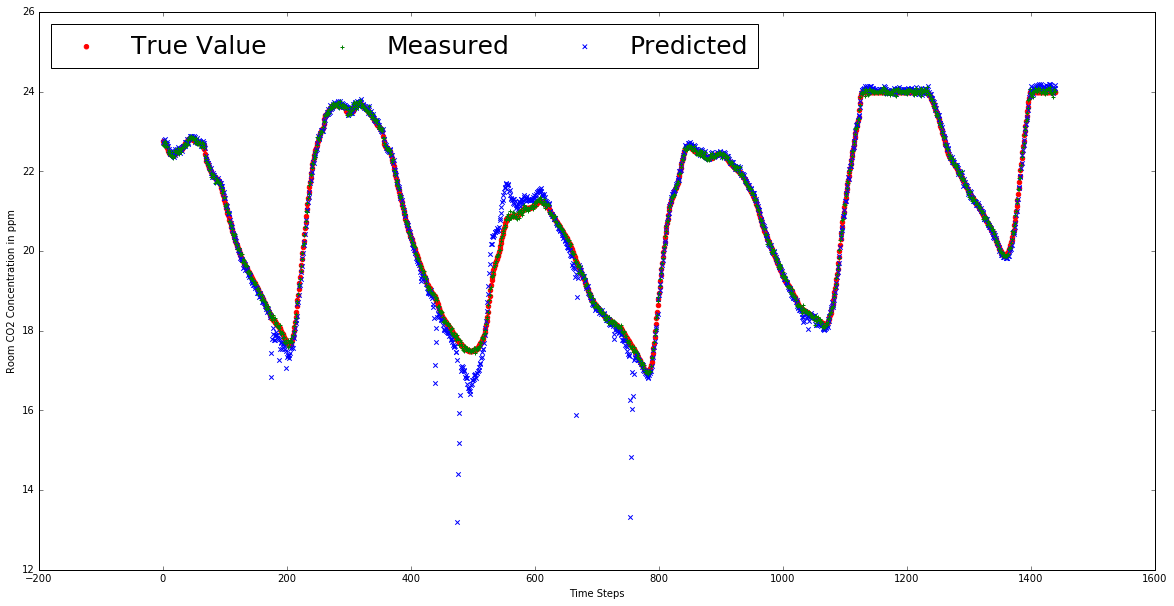

In [34]:
import matplotlib.pyplot as plt
#plotting first three days of prediction results
plot_len = (5*24*12)//step
#print(plot_len)
plot_start = 1000
if plot_start > iterations:
    plot_start = 0
if plot_len+plot_start > iterations:
    plot_len = iterations-plot_start
x = np.arange(plot_len)
#print(len(actual[start:200]))
plt.figure(figsize=(20,10))
tru = plt.scatter(x, actual[plot_start:plot_len+plot_start], color="r", marker="o")
pre = plt.scatter(x, predicted[plot_start:plot_len+plot_start], color="b", marker="x")
mea = plt.scatter(x, measured[plot_start:plot_len+plot_start], color="g", marker = "+")
plt.legend((tru,mea,pre),
           ("True Value","Measured","Predicted"),
            scatterpoints = 1,
            ncol = 3,
            fontsize=25,
            loc="upper left")
plt.xlabel("Time Steps")
plt.ylabel("Room CO2 Concentration in ppm")
plt.show()

In [35]:
print(temp_ekf.W_values)

[[ 0.00479407]
 [ 0.00010034]
 [ 0.00900801]
 [ 0.00260864]
 [ 0.00103491]
 [ 0.00358312]]


In [36]:
print(temp_ekf.X_values)

[[ 20.87820248]
 [  0.06904335]
 [  0.08058012]
 [  0.0683097 ]
 [  0.0683097 ]
 [  0.06812847]]


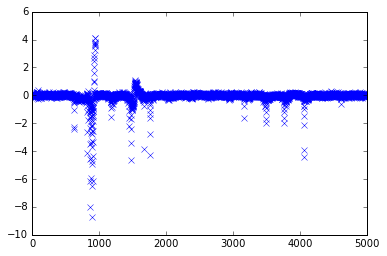

In [37]:
import operator
residues = list(map(operator.sub, predicted[start:], measured[start:]))
plt.plot(residues, 'x')
plt.show()

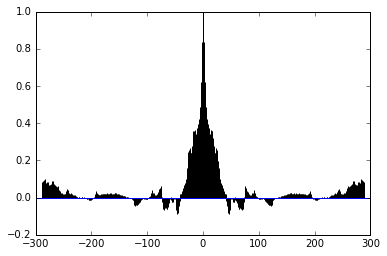

In [38]:
plt.acorr(residues, maxlags = 24*12)
plt.show()

In [39]:
normal_start = 15*24*12
if normal_start > iterations:
    normal_start = start
normal_end = 30*24*12
if normal_end > iterations:
    normal_end = iterations-1 
P1_normal = P1[normal_start:normal_end]
P2_normal = P2[normal_start:normal_end]
P3_normal = P3[normal_start:normal_end]
P4_normal = P4[normal_start:normal_end]
P5_normal = P5[normal_start:normal_end]

In [40]:
print('P1 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P1_normal),np.std(P1_normal)))
print('P2 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P2_normal),np.std(P2_normal)))
print('P3 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P3_normal),np.std(P3_normal)))
print('P4 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P4_normal),np.std(P4_normal)))
print('P5 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P5_normal),np.std(P5_normal)))

P1 ideal value is 0, estimated average is 0.006517170335154027 and std is 0.01008167269105106 
P2 ideal value is 0, estimated average is 0.00046718701998902816 and std is 0.004101771403563474 
P3 ideal value is 0, estimated average is 0.010667187474197369 and std is 0.005662229243351924 
P4 ideal value is 0, estimated average is 0.0036622934979130555 and std is 0.004775141340826666 
P5 ideal value is 0, estimated average is 0.0010190301698278239 and std is 0.0005647076547839608 


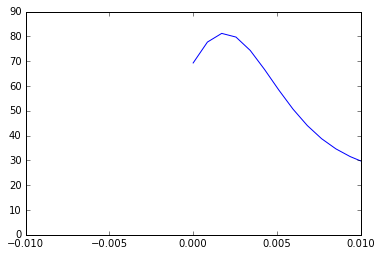

In [41]:
from scipy.stats import gaussian_kde
P1_kde = gaussian_kde(P1_normal)
P1_xs = np.linspace(min(P1_normal),max(P1_normal),200)
plt.plot(P1_xs,P1_kde(P1_xs))
plt.xlim([-0.01,0.01])
plt.show()

(-0.1, 0.1)

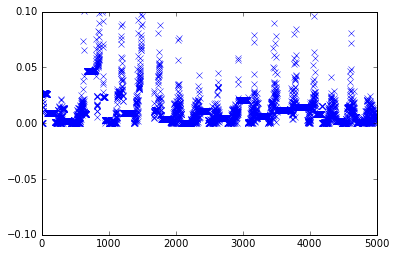

In [44]:
plt.plot(P1,'x')
plt.ylim([-0.1,0.1])

### Parameter Estimation with EKF

In [16]:
import numpy as np
import sympy
import library.EKF as EKF
import pandas as pd

In [179]:
p1, p2, p3, p4, p5, p6 = sympy.symbols('p1 p2 p3 p4 p5 p6')
x1, x2, x3, x4, x5, x6, x7 = sympy.symbols('x1 x2 x3 x4 x5 x6 x7')
states = sympy.Matrix([[x1],
                      [x2],
                      [x3],
                      [x4],
                      [x5],
                      [x6],
                      [x7]])
params = sympy.Matrix([[p1],
                      [p2],
                      [p3],
                      [p4],
                      [p5],
                      [p6]])
function = sympy.Matrix([x1+x2*p1-x1*p1+x3*p2+x4*p3+x5*p4+x6*x7*p5-x1*x7*p5+p6])
param_estimates = np.matrix([[0.0042],
                            [0.00032],
                            [0.07],
                            [0.001],
                            [0.3],
                             [0.001]])
timeCoef = 1
param_estimates *= timeCoef
P = np.eye(6)*0.01
Re = np.eye(1)*0.5

pekf = EKF.ExtendedKalmanFilterParameter(function, params, states, P, param_estimates, 
                                         Re=Re, forget=1, constrained=True)

In [180]:
data = pd.read_csv('data/EP_CO2.csv')
length = data.shape[0]
step = 1
#iterations = length
iterations = 8000
np.random.seed(1234)
IAT_noise = np.random.normal(0,0.05,iterations+1)
OAT_noise = np.random.normal(0,0.05,iterations+1)
Lux_noise = np.random.normal(0,1,iterations+1)
DAT_noise = np.random.normal(0,0.1,iterations+1)
SAP_noise = np.random.normal(0,0.001,iterations+1)
prediction = []
measurement = []
i = 1
P1 = []
P2 = []
P3 = []
P4 = []
P5 = []
P6 = []
noise_coef = 1.0

In [181]:
for i in range(1, iterations):
    IAT = data['IAT'][step*i-1] + IAT_noise[i]*noise_coef
    OAT = data['OAT'][step*i-1] + OAT_noise[i]*noise_coef
    Lux = data['Lux'][step*i-1] + Lux_noise[i]*noise_coef
    DAT = data["DAT"][step*i-1] + DAT_noise[i]*noise_coef
    SAP = data['SupplyFlow'][i-1] + SAP_noise[i]*noise_coef
    #SAP = math.sqrt(data['SAP'][i-1])
    RAD = 0
    OCC = data["OCCU"][i-1]
    controls = np.matrix([[IAT],
                          [OAT],
                          [Lux],
                          [OCC],
                          [RAD],
                          [DAT],
                          [SAP]])
    pekf.Predict(controls)
    prediction.append(pekf.prediction[0,0])
    #print(pekf.Cw_values)
    measure = np.matrix([[IAT]])
    measurement.append(IAT)
    pekf.Update(measure)
    P1.append(pekf.W_values[0,0])
    P2.append(pekf.W_values[1,0])
    P3.append(pekf.W_values[2,0])
    P4.append(pekf.W_values[3,0])
    P5.append(pekf.W_values[4,0])
    P6.append(pekf.W_values[5,0])

In [182]:
print(pekf.W_values)

[[  1.46830784e-03]
 [  3.20752725e-05]
 [  3.27861078e-02]
 [  4.75934752e-04]
 [  2.35319256e-01]
 [  2.85127786e-02]]


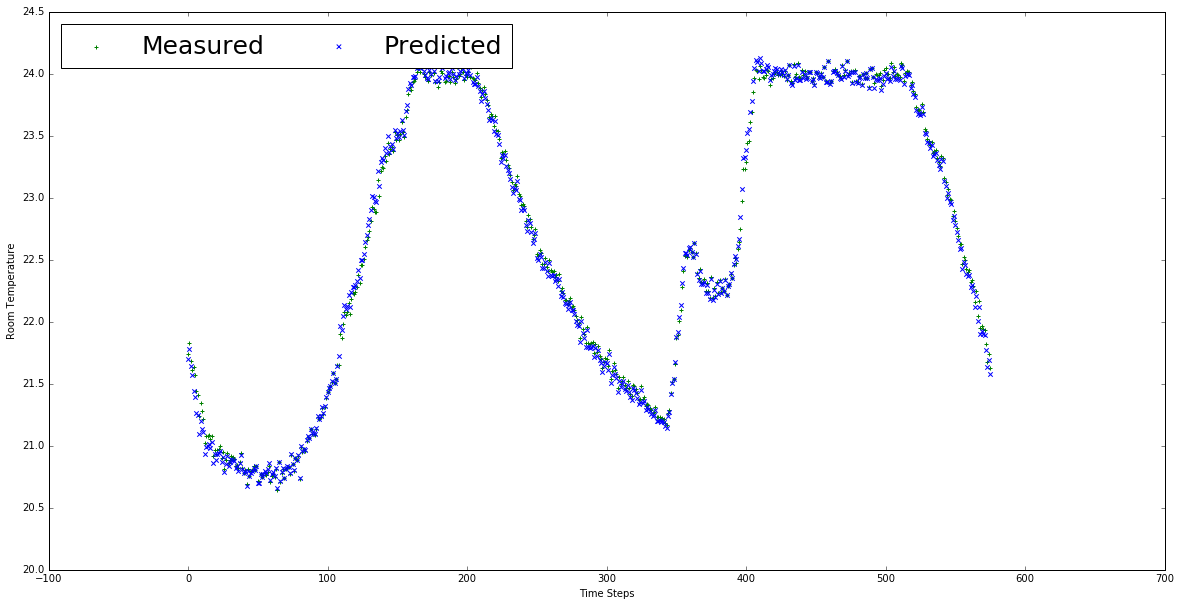

In [191]:
import matplotlib.pyplot as plt
start = 15*24*12
plot_len = (2*24*12)
if start < iterations:
    start = 0
if iterations -1 < plot_len:
    plot_len = iterations - 1
x = np.arange(plot_len)
plt.figure(figsize=(20,10))
mea = plt.scatter(x, measurement[start:plot_len+start], color="g", marker = "+")
pre = plt.scatter(x, prediction[start:plot_len+start], color="b", marker="x")
plt.legend((mea,pre),
           ("Measured", "Predicted"),
            scatterpoints = 1,
            ncol = 3,
            fontsize=25,
            loc="upper left")
plt.xlabel("Time Steps")
plt.ylabel("Room Temperature")
plt.show()

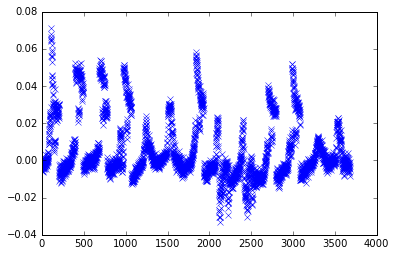

In [184]:
normal_start = 15*24*12
normal_end = 30*24*12
import operator
residues = list(map(operator.sub, prediction[normal_start:], measurement[normal_start:]))
plt.plot(residues, 'x')
plt.show()

In [185]:
P1_normal = P1[normal_start:normal_end]
P2_normal = P2[normal_start:normal_end]
P3_normal = P3[normal_start:normal_end]
P4_normal = P4[normal_start:normal_end]
P5_normal = P5[normal_start:normal_end]
P6_normal = P6[normal_start:normal_end]

In [186]:
print('P1 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P1_normal),np.std(P1_normal)))
print('P2 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P2_normal),np.std(P2_normal)))
print('P3 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P3_normal),np.std(P3_normal)))
print('P4 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P4_normal),np.std(P4_normal)))
print('P5 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P5_normal),np.std(P5_normal)))
print('P6 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P6_normal),np.std(P6_normal)))

P1 ideal value is 0, estimated average is 0.0012998987758866605 and std is 0.00010306850617584112 
P2 ideal value is 0, estimated average is 3.764594352161595e-05 and std is 3.858941017964373e-06 
P3 ideal value is 0, estimated average is 0.0376178320274299 and std is 0.004357437690843336 
P4 ideal value is 0, estimated average is 0.00047593475203844076 and std is 1.0842021724855044e-19 
P5 ideal value is 0, estimated average is 0.23346226170781698 and std is 0.0025997921129882174 
P6 ideal value is 0, estimated average is 0.029521440955969407 and std is 0.00101637557769805 


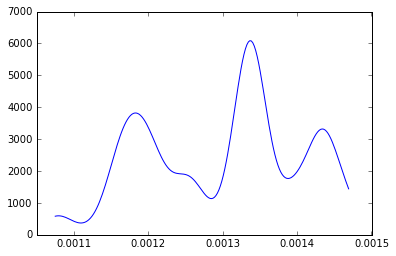

In [187]:
from scipy.stats import gaussian_kde
P1_kde = gaussian_kde(P1_normal)
P1_xs = np.linspace(min(P1_normal),max(P1_normal),200)
plt.plot(P1_xs,P1_kde(P1_xs))
plt.show()

## Real Measurement

In [169]:
import math
param_estimates = np.matrix([[0.05],
                            [0.001],
                            [0.06],
                            [0.004],
                            [0.08],
                             [0.2]])
pekf = EKF.ExtendedKalmanFilterParameter(function, params, states, P, param_estimates, 
                                         Re=Re, forget=1, constrained=True)

In [170]:
data = pd.read_csv('data/CB5208_Dataset.csv')
length = data.shape[0]
step = 1
#iterations = length
iterations = 5000
prediction = []
measurement = []
P1 = []
P2 = []
P3 = []
P4 = []
P5 = []
P6 = []
noise_coef = 0.0

In [171]:
for i in range(1, iterations):
    IAT = data['IAT'][step*i-1]
    OAT = data['OAT'][step*i-1]
    Lux = data['Lux'][step*i-1]
    DAT = data["DAT"][step*i-1]
    #SAP = data['SupplyFlow'][i-1] + SAP_noise[i]*noise_coef
    SAP = math.sqrt(data['SAP'][i-1])
    RAD = 0
    OCC = data["OCC"][i-1]
    controls = np.matrix([[IAT],
                          [OAT],
                          [Lux],
                          [OCC],
                          [RAD],
                          [DAT],
                          [SAP]])
    pekf.Predict(controls)
    prediction.append(pekf.prediction[0,0])
    #print(pekf.Cw_values)
    measure = np.matrix([[IAT]])
    measurement.append(IAT)
    pekf.Update(measure)
    P1.append(pekf.W_values[0,0])
    P2.append(pekf.W_values[1,0])
    P3.append(pekf.W_values[2,0])
    P4.append(pekf.W_values[3,0])
    P5.append(pekf.W_values[4,0])
    P6.append(pekf.W_values[5,0])

In [172]:
print(len(measurement), len(prediction), iterations)

4999 4999 5000


0 864


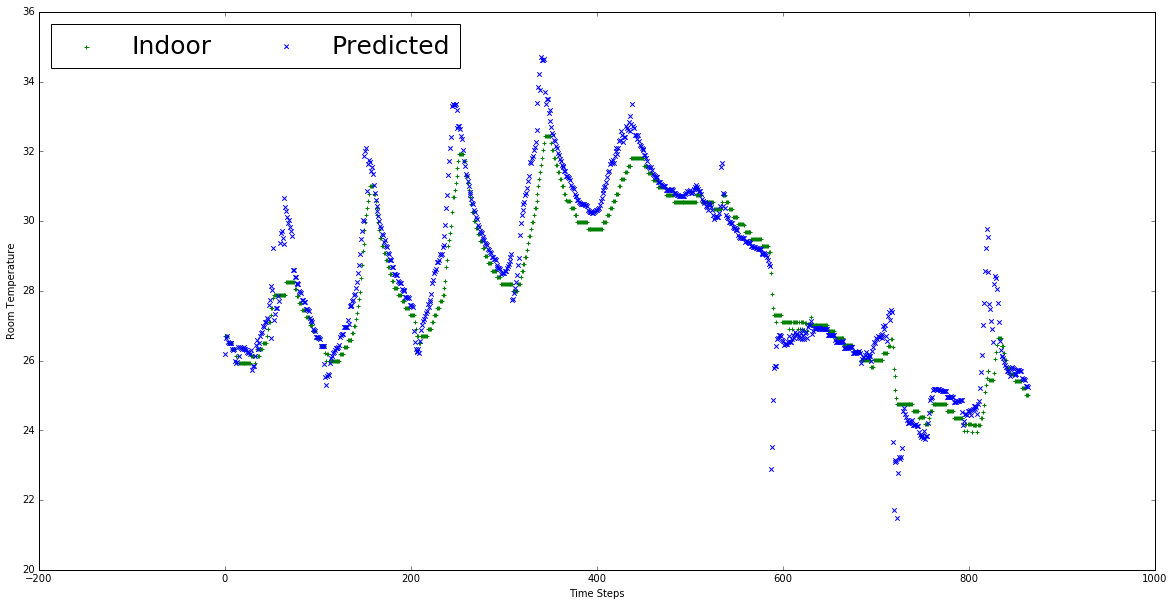

In [173]:
import matplotlib.pyplot as plt
#start = 15*24*12
start = 7*24*12
plot_len = (3*24*12)
if start < iterations:
    start = 0
if iterations -1 < plot_len:
    plot_len = iterations - 1
print(start, plot_len)
x = np.arange(plot_len)
plt.figure(figsize=(20,10))
mea = plt.scatter(x, measurement[start:plot_len+start], color="g", marker = "+")
pre = plt.scatter(x, prediction[start:plot_len+start], color="b", marker="x")
plt.legend((mea,pre),
           ("Indoor", "Predicted"),
            scatterpoints = 1,
            ncol = 3,
            fontsize=25,
            loc="upper left")
plt.xlabel("Time Steps")
plt.ylabel("Room Temperature")
plt.show()

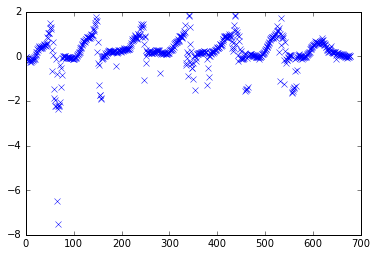

In [174]:
normal_start = 15*24*12
normal_end = 30*24*12
import operator
residues = list(map(operator.sub, prediction[normal_start:], measurement[normal_start:]))
plt.plot(residues, 'x')
plt.show()

In [175]:
P1_normal = P1[normal_start:normal_end]
P2_normal = P2[normal_start:normal_end]
P3_normal = P3[normal_start:normal_end]
P4_normal = P4[normal_start:normal_end]
P5_normal = P5[normal_start:normal_end]
P6_normal = P6[normal_start:normal_end]

In [176]:
print('P1 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P1_normal),np.std(P1_normal)))
print('P2 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P2_normal),np.std(P2_normal)))
print('P3 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P3_normal),np.std(P3_normal)))
print('P4 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P4_normal),np.std(P4_normal)))
print('P5 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P5_normal),np.std(P5_normal)))
print('P6 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P6_normal),np.std(P6_normal)))

P1 ideal value is 0, estimated average is 0.05882289452306444 and std is 0.0005005113498443883 
P2 ideal value is 0, estimated average is 0.001321994675422588 and std is 0.00019215431732913656 
P3 ideal value is 0, estimated average is 0.0189538935173774 and std is 0.011782447809533855 
P4 ideal value is 0, estimated average is 0.0023312007371162347 and std is 0.001799670007969535 
P5 ideal value is 0, estimated average is 0.09197139082327686 and std is 0.0019604600210168742 
P6 ideal value is 0, estimated average is 0.9894900651434382 and std is 0.00529129264994278 


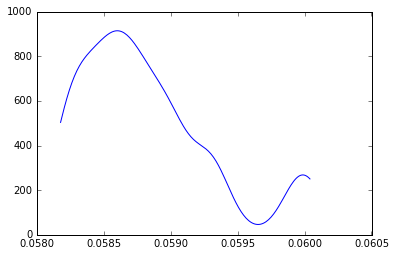

In [177]:
from scipy.stats import gaussian_kde
P1_kde = gaussian_kde(P1_normal)
P1_xs = np.linspace(min(P1_normal),max(P1_normal),200)
plt.plot(P1_xs,P1_kde(P1_xs))
plt.show()

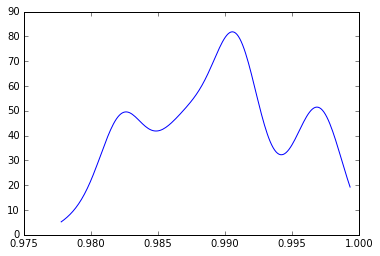

In [178]:
P6_kde = gaussian_kde(P6_normal)
P6_xs = np.linspace(min(P6_normal),max(P6_normal),200)
plt.plot(P6_xs,P6_kde(P6_xs))
plt.show()